# Titanic Competition Submission - Brandon 

Hi! This is my second competition for Data Science. In this case, we are going to be talking about the Titanic shipwreck, and we are going to try to predict which passengers survived based on some of the features the dataset provides to us. This will be a Classification problem instead of a Regression problem, because we want to classify the passengers as survivors or not. 
Let's have some fun!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
print('Files were loaded correctly')

Files were loaded correctly


## 0. Introduction

Now that we loaded up the data sets we are going to be using, we need to understand what data we are dealing with. First, let's check the first rows of our training set and see the column names. 

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.shape

(891, 12)

### Understanding our dataset
We can observe that our dataframe has 12 columns, and 891 total entries. Each column stands for different features of the passengers, so let's describe each of the features. 
* Survival: Indicates if the passenger survived or not
* pclass: Indicates the ticket class of the passenger (1st, 2nd or 3rd class)
* sex: Indicates the sex of the passenger (duh)
* Age: Indicates the age of the passenger
* sibsp: Indicates the number of siblings or spouses in the Titanic 
* parch: Indicates the number of parents or children in the Titanic 
* ticket: Indicates the ticket number
* fare: Indicates the passenger fare 
* cabin: Indicates the cabin number 
* embarked: Indicates the porf of embarkation (C for Cherbourg, Q for Queenstown, S for Southampton)

Alright, so now that we know what we are talking about, let's have a general description of our dataset with the .describe() function.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


As you can see, we have some missing information in the Age and Cabin columns. Now that we know which values are missing, as well as the type of each variable, we can start doing some data exploration.

## 1. Data Exploration

We are not dealing with only one type of variable in this dataframe, so we need to analyze them as either categorical or numerical variables. 

### 1.1 Categorical variables

#### 1.1.1 Variable: Sex

In [6]:
train['Sex'].value_counts(dropna = False)

male      577
female    314
Name: Sex, dtype: int64

In [7]:
train[['Sex','Survived']].groupby('Sex', as_index = False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


<AxesSubplot:xlabel='Sex', ylabel='Survived'>

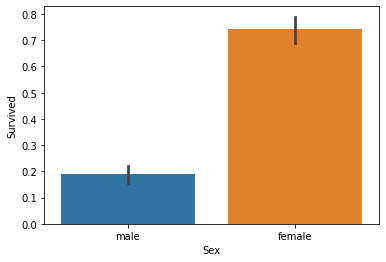

In [8]:
sns.barplot(x = 'Sex', y = 'Survived', data = train)

Here we can observe that you had the most chances of survival if you were a female aboard the Titanic. This makes sense as women and children are the first to evacuate the ship in case of disaster. 

#### 1.1.2 Variable: Pclass

In [9]:
train['Pclass'].value_counts(dropna = False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
train[['Pclass','Survived']].groupby('Pclass', as_index = False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

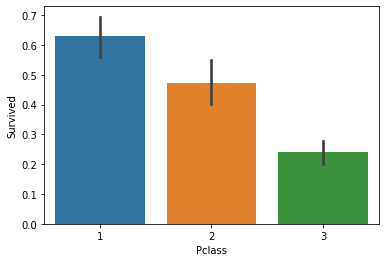

In [11]:
sns.barplot(x = 'Pclass',y = 'Survived', data = train)

The Pclass features shows us how you had more probabilities of surviving if you were in a higher class (That's kind of sad). Let's see how it looks like taking in account your sex and your ticket class.

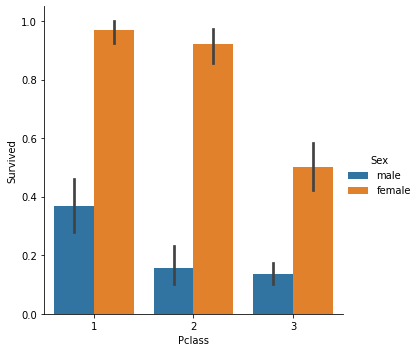

In [12]:
sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar')

As we can observe, you had higher chances of surviving if you had a higher class ticket. This applies to both female and male.

#### 1.1.3 Variable: Embarked

In [13]:
train['Embarked'].value_counts(dropna = False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [14]:
train[['Embarked','Survived']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

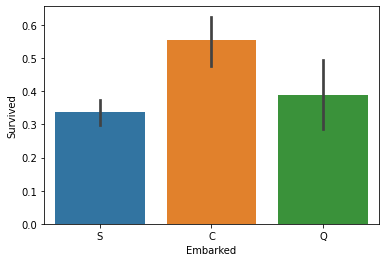

In [15]:
sns.barplot(x = 'Embarked', y = 'Survived', data = train)

Here we can see a relationship between the port they embarked on and their survival probabilities. Let's check if this has anything to do with either sex or ticket class.

<AxesSubplot:xlabel='Embarked', ylabel='Pclass'>

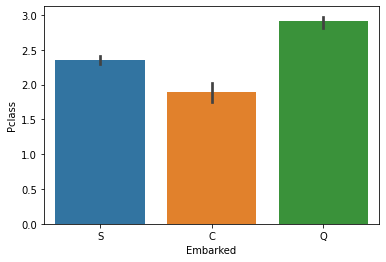

In [16]:
sns.barplot(x = 'Embarked', y = 'Pclass', data = train)

In [17]:
train[['Embarked','Pclass']].groupby('Embarked', as_index = False).mean()

,Embarked,Pclass
0,C,1.886905
1,Q,2.909091
2,S,2.350932


As we can see, at port C most people that embarked were from higher class in average. This makes sense why the people from that port in average had a better survival rate

### 1.2 Numerical Variables

Now that we analyzed all of the categorical variables, we will proceed to analyze the numerical variables. 
For this, we will proceed and eliminate the outliers and then analyze the dataset.

In [18]:
##Code provided by Jason Chong
def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers
    
outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)
 
      

We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


What this functions does is take our dataset, and for each of our numerical variables (Age, SibSp, Parch and Fare) go and look for any outliers. Then, it prints out the indices for the rows that contain these values. 

In [19]:
train.loc[outliers_to_drop, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [20]:
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print('Rows = {} '.format(len(train)))

Rows = 881 


Now that we dropped our outliers, let's begin with the analysis.


#### 1.2.1 General Approach

<AxesSubplot:>

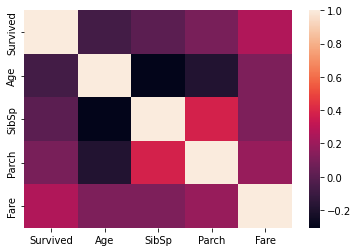

In [21]:
sns.heatmap(train[['Survived','Age', 'SibSp', 'Parch', 'Fare']].corr())

As we can see from the heatmap, Fare is the only feature that has a significant correlation with our survival rate. 

#### 1.2.2 Variable: SibSp

In [22]:
train['SibSp'].value_counts(dropna = False)

0    608
1    209
2     28
4     18
3     13
5      5
Name: SibSp, dtype: int64

In [23]:
train[['SibSp','Survived']].groupby('SibSp', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

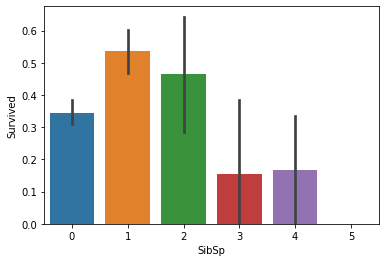

In [24]:
sns.barplot(x = 'SibSp', y = 'Survived', data = train)

#### 1.2.3 Variable: Parch

In [25]:
train['Parch'].value_counts(dropna = False)

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [26]:
train[['Parch','Survived']].groupby('Parch', as_index = False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.542857
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


<AxesSubplot:xlabel='Parch', ylabel='Survived'>

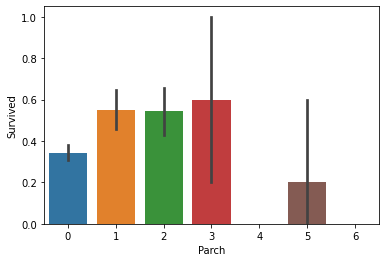

In [27]:
sns.barplot(x = 'Parch', y = 'Survived', data = train)

In [28]:
train['Age'].value_counts(dropna = False)

NaN      170
24.00     29
22.00     27
18.00     26
28.00     25
        ... 
36.50      1
55.50      1
0.92       1
23.50      1
74.00      1
Name: Age, Length: 89, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

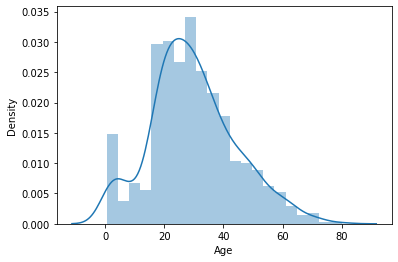

In [29]:
sns.distplot(train['Age'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


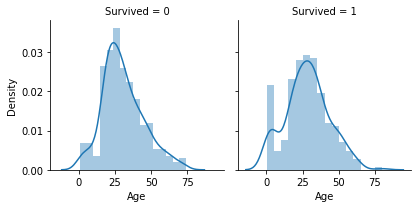

In [30]:
g = sns.FacetGrid(train, col= 'Survived')
g.map(sns.distplot, 'Age')

As we can see, passengers with less age (younger) had the most probability of surviving. This makes sense, because children are the first to be evacuated in case of a shipwreck. 
Now that we finished our EDA, let's start with the Machine Learning models to see if we can predict if a passenger survived or not.

## 2. Data Preprocessing

Now, we want to prepare the data for our Machine Learning models. This includes dropping null values, transforming the data with logarithmic functions to eliminate skewness, and create new variables that can provide useful information for our models (Feature Engineering)

### 2.1 Drop and fill missing values

Let's check which features have missing values

In [31]:
train.isnull().sum().sort_values(ascending = False)

Cabin          680
Age            170
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [32]:
test.isnull().sum().sort_values(ascending = False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

#### 2.1.1 Ticket and Cabin Columns

In [33]:
train = train.drop(['Ticket','Cabin'], axis = 1)
test = test.drop(['Ticket','Cabin'], axis = 1)

Here I decided to drop the Ticket and Cabin columns because they do not offer any relevant information to the study. However, we can come back at another time to pay closer attention to these variables, and see if they have any influence to the survival probability of the passengers. 

#### 2.1.2 Embarked (Train Set)

Let's pay close attention to the Embarked column. Here it says we have two missing entries. Here we can either drop the two missing entries, or replace it with the most common value. Since we are talking here of a feature that has only three options, we can replace it with the most common value. 

In [34]:
mode = train['Embarked'].dropna().mode()[0]
mode

'S'

In [35]:
train['Embarked'].fillna(mode, inplace = True)

In [36]:
train.isnull().sum().sort_values(ascending = False)

Age            170
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

Now that we succesfuly filled the missing values in our **training** set for embarked, let's see which missing values we have in our **test** set.

In [37]:
test.isnull().sum().sort_values(ascending = False)

Age            86
Fare            1
PassengerId     0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
Embarked        0
dtype: int64

#### 2.1.3 Fare (Test Set)

Here I will replace the Fare missing value with the median, so let's first calculate it and then fill the missing entry. 

In [38]:
median = test['Fare'].dropna().median()
median

14.4542

In [39]:
test['Fare'].fillna(median, inplace = True)

In [40]:
test.isnull().sum().sort_values(ascending = False)

Age            86
PassengerId     0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
Fare            0
Embarked        0
dtype: int64

#### 2.1.4 Age (Train and Test set)

Alright, so now the only feature that has missing values is the Age variable. We are going to merge the train and test set, to fill in the missing values and have as much data as possible to have the most accurate prediction for the age group.

In [41]:
combine = pd.concat([train, test], axis = 0).reset_index(drop = True)
combine.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1299.000000,881.000000,1299.000000,1043.000000,1299.000000,1299.000000,1299.000000
mean,657.093149,0.385925,2.294072,29.903806,0.452656,0.372594,32.555112
std,377.743244,0.487090,0.837150,14.427548,0.879416,0.857157,50.677613
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,331.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,657.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,984.500000,1.000000,3.000000,39.000000,1.000000,0.000000,30.597900
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


Here we have succesfully merged our two sets, and we can see that we have a total count of 1299 passengers, and only 881 have the survived variable filled out. This makes sense, as only the training set had that variable filled. Now, let's check out our missing values for our combined dataset.

In [42]:
combine.isnull().sum().sort_values(ascending = False)

Survived       418
Age            256
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

So we can confirm that we have 256 missing values for age. What we are going to do to fill out these values is to see which variables are strongly correlated to the Age variable, and try to use them to predict the missing values for age. To do this, we need to make sure that our variables can be compared, and for that we need to do some encoding. This means we will turn our categorical variables into "numerical" variables, like for example Sex. Check out the following example

In [43]:
combine['Sex'] = combine['Sex'].map({'male':0, 'female':1})
combine['Sex']

0       0
1       1
2       1
3       1
4       0
       ..
1294    0
1295    1
1296    0
1297    0
1298    0
Name: Sex, Length: 1299, dtype: int64

As you can see, we transformed the variable from displaying "male" or "female" to 0 or 1. This still gives us the message that the passenger is either male or female, but the numerical value can be now compared to the other numerical variables more easily. 

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


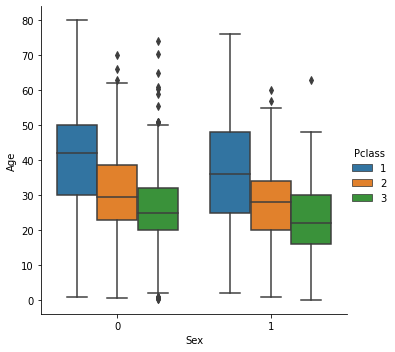

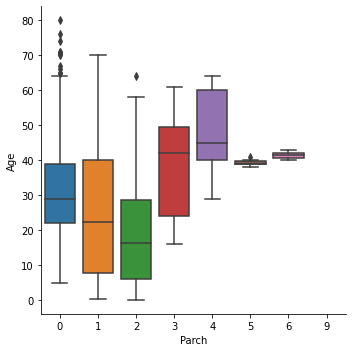

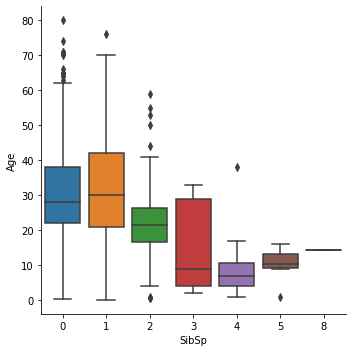

In [44]:
sns.factorplot(x = 'Sex', y = 'Age', hue = 'Pclass', kind = 'box', data = combine)
sns.factorplot(x = 'Parch', y = 'Age', kind = 'box', data = combine)
sns.factorplot(x = 'SibSp', y = 'Age', kind = 'box', data = combine)

<AxesSubplot:>

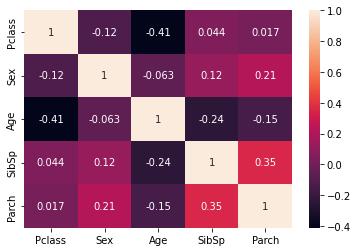

In [45]:
sns.heatmap(combine.drop(['Survived', 'PassengerId','Name','Fare'], axis = 1).corr(), annot = True)

So now that we see the correlation between Age and the different values, let's fill out the missing values depending on how the entries are related to each other. What we will do is the following: Search for the missing entries that have similar Pclass, Sex and SibSp, and fill the ones that have the missing values with the median of the ones that do have the Age feature filled out. If there are no similar entries with the Age filled, we will fill it out with the median of the entire age column. 

In [46]:
## Code provided by Jason Chong
age_nan_indices = list(combine[combine['Age'].isnull()].index)
                       
for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp'])
                                & (combine['Parch'] == combine.iloc[index]['Parch'])
                                & (combine['Pclass'] == combine.iloc[index]['Pclass'])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [47]:
combine['Age'].isnull().sum()
combine.isnull().sum().sort_values(ascending = False)

Survived       418
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

Now that we have succesfully eliminated all of the missing values, let's do some data transformation to our dataset to improve our model accuracy. 

### 2.2 Data transformation

As you can recall, we had very high skewness on our Age variable, which can affect our model's performance. To solve this, we will use logarithmic transformation to reduce the skewness and normalize our data.

## 3. Feature Engineering

## 4. Machine Learning Implementation